Logistic regression is a popular machine learning model used for classifying discrete variables. When implementing this model, most people rely on some machine learning package or API: just hand over a dataset, pick a few parameters and out come the predictions. However, I've never been a fan of using black boxes without first understanding how they function. In fact, stepping behind the curtains of this classifier provides a segue to more complex models such as support vector machines and neural networks. Therefore, this post will explore the inner workings of logistic regression classifiers and demonstrate how to construct one from scratch.
<!-- TEASER_END -->

**Logistic regression classifiers compute the probability that an observation belongs to one of two classes**. If the probability exceeds some threshold, the observation is assigned to one class, or else assigned to the other class. For example, such a classifier can decide whether an email is spam or not. Rather than explicitly programming an intricate rule that dictates how the classification should take place, we allow the classifier to *learn* from a labeled training dataset and figure out the rule for itself&mdash;a hallmark of machine learning. Since the training set informs the classifier of what right and wrong answers look like, this is an example of **supervised learning**.

# Table of contents
1. [Inspecting the data](#cell1)
2. [Developing a hypothesis using the logistic function](#cell2)
3. [Measuring prediction error using the cost function](#cell3)
4. [Minimizing the cost function with gradient descent](#cell4)
5. [Training the classifier and making predictions](#cell5)
6. [Assessing and improving performance](#cell6)

<a id="cell1"></a>
# 1. Inspecting the data

Before diving in, let's take a look at the training set we'll be working with and identify what we're trying to predict.

In [1]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the dataset into a DataFrame using the first row as column labels
df = pd.read_csv('data/election.csv', header=0)

# Display first five rows
df.head()

,funds,rating,result
0,0.236,0.302,won
1,0.260,0.270,won
2,0.162,0.305,won
3,0.376,0.337,won
4,0.308,0.362,won


The training set comprises hypothetical historical election data for mayoral candidates in a country. Here's a description of each column:

- `funds` - campaign money (in millions) raised by the candidate
- `rating` - the candidate's average rating (ranging from 0 to 1) as determined by public opinion polls
- `result` - whether the candidate won or lost the election

`funds` and `rating` are the **features** while `result` is the **target variable** that define the classes: winners and losers. Using this training set and a logistic regression classifier, **we aim to predict if a future candidate will win an election.**

Since we'll need to eventually perform computations on the target variable, let's go ahead and encode its values with numbers: "won" = 1 and "lost" = 0. 

In [2]:
# Encode the values in the target variable as numbers
df.loc[df['result'] == 'won', 'result'] = 1
df.loc[df['result'] == 'lost', 'result'] = 0

# Convert the target variable column to integer type
df['result'] = df['result'].apply(pd.to_numeric)

# Display the first five rows
df.head()

,funds,rating,result
0,0.236,0.302,1
1,0.260,0.270,1
2,0.162,0.305,1
3,0.376,0.337,1
4,0.308,0.362,1


## Visualizing the data

Now let's dive deeper into the training set and visualize it.

In [3]:
df.describe()

,funds,rating,result
count,264.000000,264.000000,264.000000
mean,1.080432,0.452564,0.484848
std,0.505437,0.213956,0.500720
min,0.088000,0.059000,0.000000
25%,0.679000,0.273750,0.000000
50%,1.081000,0.456000,0.000000
75%,1.514500,0.604500,1.000000
max,2.000000,0.935000,1.000000


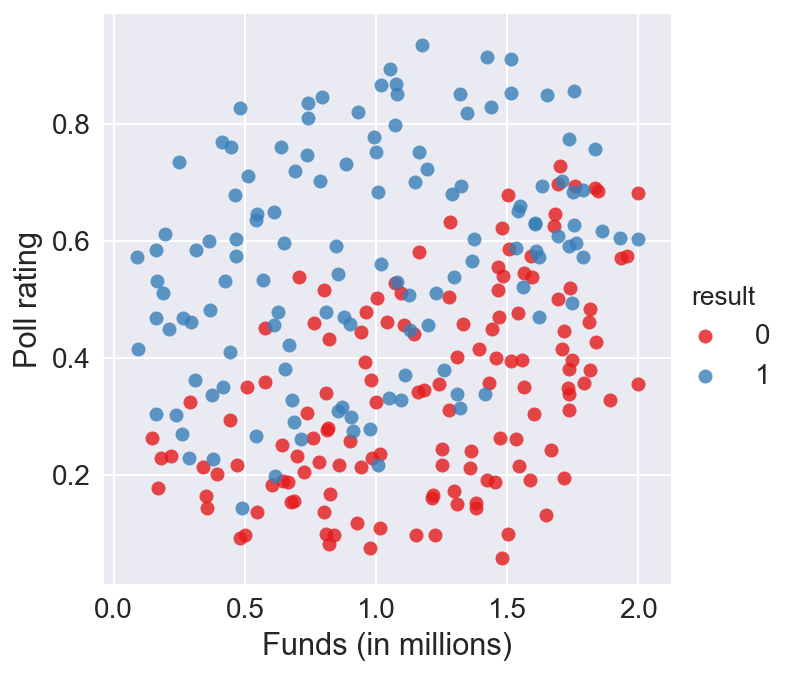

In [4]:
# Improve readability of figures
sns.set_context('notebook', font_scale=1.4)

# Display a scatterplot of the training set and label the axes
sns.lmplot(
    data=df,
    x='funds',
    y='rating',
    hue='result',
    fit_reg=False,
    palette='Set1'
).set_axis_labels('Funds (in millions)', 'Poll rating');

It looks like we have data for 264 candidates, or **training examples**. A quick glance at the training set indicates the two classes are generally found above and below some straight line. In order to make predictions, the classifier will need to estimate this line, or **decision boundary**. However, before predicting anything, we first need the classifier to compute win probabilities given `funds` and `rating`. 

<a id="cell2"></a>
# 2. Developing a hypothesis using the logistic function

Machine learning models are based on some mathematical function that processes the features $x$ and outputs a value; this function is called the **hypothesis** $h(x)$. Since our classifier of interest outputs probabilities, $h(x)$ must be between zero and one. We can't use linear functions because probabilities below zero or above one don't make any sense. Therefore, we'll turn to the **logistic function**:

$$g(z) = \frac{1}{1+\mathrm{e}^{-z}}$$

Let's see what this function looks like.

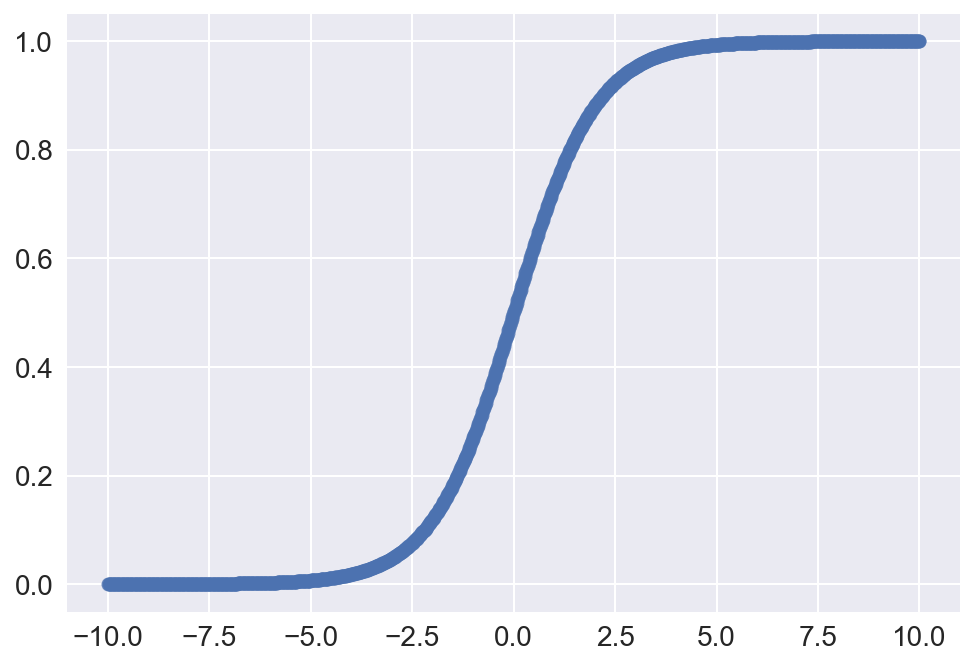

In [5]:
# Compute the logistic function over a range of values
x_values = np.linspace(-10, 10, 1000)
g_values = special.expit(x_values)

# Display the logistic function
sns.regplot(
    x=x_values,
    y=g_values,
    fit_reg=False
);

We see that $\lim_{z\rightarrow\infty}g(z) = 1$ and $\lim_{z\rightarrow-\infty}g(z) = 0$, which is perfect since we're working with probabilities. The question remains: how do we incorporate the features into the logistic function to develop a hypothesis? Since we've been thinking of a linear decision boundary, perhaps a [linear combination](https://en.wikipedia.org/wiki/Linear_combination) of the features will suffice:

$$z = \theta_0{x_0} + \theta_1{x_1} + \theta_2{x_2}$$

- $x_1$ and $x_2$ are `funds` and `rating`, respectively
- $x_0 = 1$
- $\theta_0$, $\theta_1$ and $\theta_2$ are real numbers

If we input this expression into the logistic function, we have a potential hypothesis for the classifier:

$$h_\theta(x) = g(\theta_0{x_0} + \theta_1{x_1} + \theta_2{x_2}) = \frac{1}{1+\mathrm{e}^{-(\theta_0{x_0} + \theta_1{x_1} + \theta_2{x_2})}}$$

Specifically, **this hypothesis computes the probability that a candidate will win an election given `funds` and `rating`.** But how do we know if this is a suitable hypothesis? Well, if we set $z = 0$, then $h_\theta(x) = g(0) = 0.5$. This probability value has some significance&mdash;it serves as an intuitive threshold for making predictions. That is, we can deem a candidate will win the election if the win probability equals or exceeds 50% (i.e., $h_\theta(x)\ge0.5$), otherwise he/she is predicted to lose. Setting $z = 0$ has another intriguing result: it transforms the above linear combination into the equation of a line: 

$$x_2=-\frac{\theta_0}{\theta_2}-{\frac{\theta_1}{\theta_2}}x_1$$

Because this line is linked to our threshold for making predictions, logically, this must be the decision boundary of the classifier! It looks like our choice for the hypothesis wasn't so arbitrary after all. Now all that remains is to identify what are the **parameters** of the hypothesis: $\theta_0$, $\theta_1$ and $\theta_2$. 

<a id="cell3"></a>
# 3. Measuring prediction error using the cost function

The classifier will use our newly formulated hypothesis $h_\theta(x)$ and its parameters $\theta$ to compute the win probabilities for each training example. Hopefully, the *actual winners* have win probabilities near one, while the *actual losers* near zero. The win probability of an actual winner, which is equivalent to the probability of correctly classifying an actual winner, is given by

$$P(y = 1 \mid x_{winner}) = h_\theta(x_{winner})$$

where $y$ is the target variable. Since we're performing binary classification, the probability of correctly classifying an actual loser is given by

$$P(y = 0 \mid x_{loser}) = 1-h_\theta(x_{loser})$$

Therefore, the probability of correctly classifying *every* actual winner in the training set (assuming each training example was independently generated) is the product of their individual probabilities: $\prod_{winners}h_\theta(x)$. Conversely, the probability of correctly classifying every actual loser is $\prod_{losers}(1-h_\theta(x))$. Taken together, the joint product represents **the probability of correctly classifying all of the training examples**: 

$$\displaystyle\prod_{y=1}h_\theta(x)\displaystyle\prod_{y=0}(1-h_\theta(x))$$

This joint product can be combined and written more succinctly, and is called the **likelihood** of the data for a set of parameters:

$$\mathcal{L}(\theta) = \displaystyle\prod_{i=1}^{m}h_\theta(x_i)^{y^{(i)}}(1-h_\theta(x_i))^{1-y^{(i)}}$$

where $m$ is the number of training examples. Since we'd like to maximize the probability of correctly classifying the training set, we need to maximize $\mathcal{L}(\theta)$. It turns out that it's much easier to maximize its logarithm:

$$\ln{\mathcal{L}(\theta)} =\sum_{i=1}^{m}{y}^{(i)}\ln{h(x^{(i)})} + (1 - y^{(i)})\ln(1 - h(x^{(i)}))$$

Maximizing $\ln{\mathcal{L}(\theta)}$ is equivalent to *minimizing* its negative:

$$-\ln{\mathcal{L}(\theta)} = \sum_{i=1}^{m}{-y}^{(i)}\ln h(x^{(i)}) - (1 - y^{(i)})\ln(1 - h(x^{(i)}))$$

This expression represents the probability of *incorrectly* classifying the training set, or in other words, the total error or cost of the predictions. The mean cost of a prediction can then serve as a convenient metric for how well the classifier performs, and is called the **cost function**:

$$C(\theta) = \frac{1}{m}\sum_{i=1}^{m}{-y}^{(i)}\ln h(x^{(i)}) - (1 - y^{(i)})\ln(1 - h(x^{(i)}))$$

**Our goal is to the identify the parameters $\theta$ that minimize the cost function.** Programming the cost function would typically require nested `for` loops and/or the use of `sum()`. A more elegant and computationally efficient method takes advantageous of linear algebra to arrive at a vectorized version:

$$C(\vec{\theta}) = \frac{1}{m}\Big({-\mathbf{y}}^T\ln g({X}{\vec\theta}) - (1 - \mathbf{y})^T\ln(1 - g({X}{\vec\theta}))\Big)$$
$$\\$$
$$\vec{\theta}=
\left[\begin{array}{cccc}
\theta_0 \\
\theta_1 \\
\theta_2 
\end{array}\right]\quad{X}=
\left[\begin{array}{cccc}
x_0 & x_1^{(1)} & x_2^{(1)} \\
x_0 & x_1^{(2)} & x_2^{(2)} \\
\vdots & \vdots & \vdots \\
x_0 & x_1^{(m)} & x_2^{(m)}
\end{array}\right]\quad\mathbf{y}=
\left[\begin{array}{cccc}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(m)}
\end{array}\right]$$
$\\$

In [6]:
def cost_function(X, y, theta):    
    # Compute the number of training examples
    m = len(X) 
    
    hypothesis = special.expit(X.values @ theta)
    return (
        (-(y.values.T) @ np.log(hypothesis)) -
        ((1 - y.values).T @ np.log(1 - hypothesis))
    ) / m

## Setting up the features and target variable

While we're here, let's place our features into a **design matrix** $X$.

In [7]:
# Compute the number of training example
m = len(df)

# Set up a design matrix with the first column as ones
X = pd.concat(
    (pd.Series(np.ones(m), name='x0'), df[['funds', 'rating']]),
    axis=1
)

# Display the first five rows
X.head()

,x0,funds,rating
0,1.0,0.236,0.302
1,1.0,0.260,0.270
2,1.0,0.162,0.305
3,1.0,0.376,0.337
4,1.0,0.308,0.362


Let's also set up the target variable in a vector $\mathbf{y}$.

In [8]:
# Store the target variable as a separate vector
y = df.loc[:, 'result':]

# Display the first five rows
y.head()

,result
0,1
1,1
2,1
3,1
4,1


<a id="cell4"></a>
# 4. Minimizing the cost function with gradient descent 

Because the cost function $C(\theta)$ of a logistic regression classifier is [convex](http://mathgotchas.blogspot.com/2011/10/why-is-error-function-minimized-in.html), $C(\theta)$ is guaranteed to have a global minimum&mdash;we just need to find the corresponding parameters $\theta$. Unfortunately, there's no known [closed-form solution](https://www.quora.com/Does-there-exist-an-analytical-solution-to-Logistic-Regression-similar-to-that-of-the-Normal-Equation-for-Linear-Regression) that conveniently provides us these values&mdash;the classifier will need to *learn* them from the training set.

One learning algorithm is called **batch gradient descent**. Here's how it works:

1. Select arbitrary values for the parameters $\theta$
2. Compute the steepness, or gradient of $C(\theta)$ at the current values of $\theta$
3. Subtract the gradient from all values of $\theta$ *simultaneously*
4. Repeat step 2 and 3 until the gradient approaches zero, i.e., the values of $\theta$ have converged and we've reached the minimum of $C(\theta)$

Put simply, this algorithm takes steps opposite the direction of steepest increase of $C(\theta)$, updating the parameters each time, and thereby, arrives closer and closer to its minimum. The gradient of $C(\theta)$ is given by its partial derivatives with respect to the parameters $\theta$:

$$\frac{\partial}{\partial\theta_j}C(\theta) = \frac{1}{m}\sum_{i=1}^{m}{x_j}^{(i)}({h_\theta}(x^{(i)}) - y^{(i)})$$

where $j = 0, 1\dots n$ with $n$ being the number of features. This algorithm is called *batch* gradient descent because we process every single training example prior to computing the gradient and updating the parameters. The update formula used by the algorithm on each iteration is

$$\theta_j := \theta_j - \frac{\alpha}{m}\sum_{i=1}^{m}{x_j}^{(i)}({h_\theta}(x^{(i)}) - y^{(i)})$$

where $\alpha$ dictates how large of a step is taken, and is called the **learning rate**. If $\alpha$ is too small, we could take a long time to reach the minimum of $C(\theta)$. On the other hand, if $\alpha$ is too large, we may overshoot the minimum and the parameters may also oscillate or diverge! Once we approach the minimum, we'll plug in the final values for the parameters $\theta$ into the hypothesis $h_\theta(x)$ and the classifier will be ready to make predictions!

A vectorized version of the update formula is

$$\vec{\theta} := \vec{\theta} - \frac{\alpha}{m}{X^T}({g(X\vec{\theta}) - \mathbf{y}})$$

Let's also keep track of the magnitude of the cost function after each iteration so we can confirm that we've reached its minimum.

In [9]:
def gradient_descent(X, y, alpha, iterations):
    m = len(X)
    
    # Select arbitrary initial values for the parameters
    curr_theta = np.zeros((X.shape[1], 1))
    
    # Create an empty array to track the cost function on each iteration
    cost_values = np.empty(iterations)
    
    for iteration in range(iterations):
        # Simultaneously update all parameters
        hypothesis = special.expit(X.values @ curr_theta)
        curr_theta -= (X.values.T @ (hypothesis - y.values)) * alpha / m
        
        # Record the current cost function
        cost_values[iteration] = cost_function(X, y, curr_theta)     
    return curr_theta, cost_values

<a id="cell5"></a>
# 5. Training the classifier and making predictions

Prior to running batch gradient descent on the classifier, we need to select a learning rate and the desired number of iterations.

In [10]:
# Set the learning rate and number of iterations
alpha = 1
iterations = 1500

It's finally time to train the logistic regression classifier!

In [11]:
# Train the classifier
theta, cost_history = gradient_descent(X, y, alpha, iterations)

# Display the parameters 
for i, parameter in enumerate(theta):
    print('theta{} = {}'.format(i, parameter))

theta0 = [-1.73093143]
theta1 = [-2.36802783]
theta2 = [ 9.47343264]


Using batch gradient descent, the classifier has learned the parameters $\theta$ that minimize the cost function, has a functional hypothesis, and is ready to make predictions. However, let's first confirm we've truly minimized the cost function by visualizing its value at each iteration.

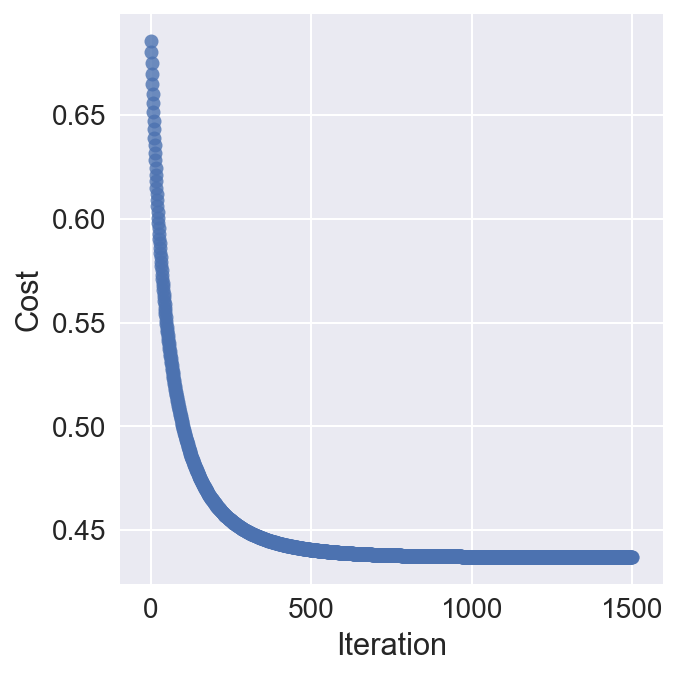

In [12]:
# Display a scatterplot of the cost function at each iteration
sns.lmplot(
    x='Iteration',
    y='Cost',
    data=pd.DataFrame(
        {'Iteration': range(iterations), 'Cost': cost_history}
    ),
    fit_reg=False
);

Excellent, the cost function converges so we don't need to alter our choices for $\alpha$ and `iterations`. Let's now use the learned parameters to visualize the linear decision boundary of the classifier.

In [13]:
# Compute the values of the decision boundary using the parameters and a range
# of feature values
x_vals = np.linspace(
    X['funds'].min(),
    X['funds'].max(),
    iterations
)
db_vals = (-theta[0, 0] - (theta[1, 0] * x_vals)) / theta[2, 0]

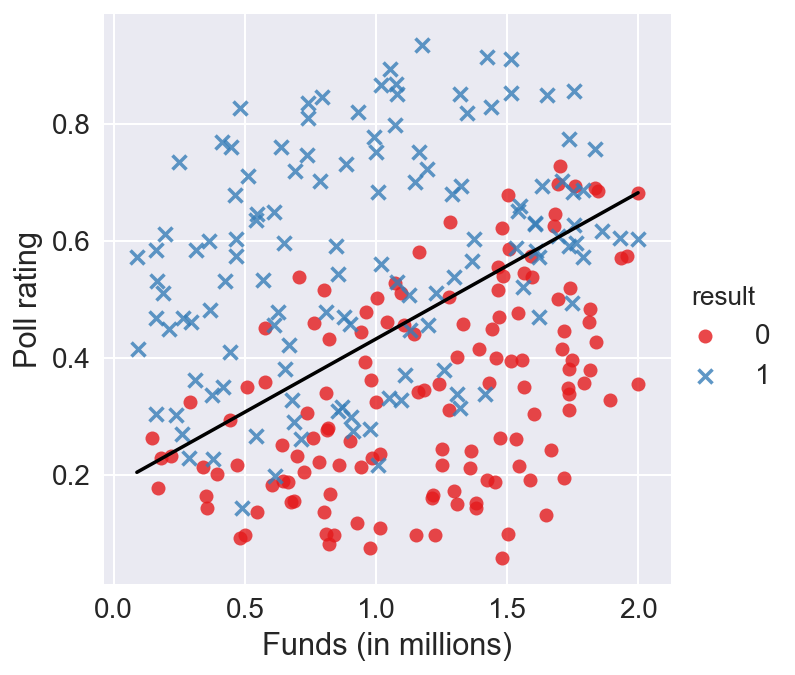

In [14]:
# Display a scatterplot of the training set and label the axes
sns.lmplot(
    data=pd.concat((X, y), axis=1),
    x='funds',
    y='rating',
    hue='result',
    fit_reg=False,
    markers=['o', 'x'],
    palette='Set1'
).set_axis_labels('Funds (in millions)', 'Poll rating');

# Display the decision boundary
plt.plot(
    x_vals,
    db_vals,
    color='black'
);

## The crystal ball awaits

Let's use the classifier on a **test example** and determine the probability that a candidate with 1.1 million in campaign funds and a poll rating of 0.52 will win a mayoral election. 

In [15]:
# Insert a value of one to account for x0
test_example = np.array([1, 1.1, 0.52])

# Compute the win probability
special.expit(test_example @ theta)

array([ 0.64346218])

It looks like this candidate has a 64% chance of winning! Not bad. We can compute the classifier's accuracy by examining how well it makes predictions on the training set. We'll make use of the threshold probability decided earlier: if $h_\theta(x) \ge 0.5$, we predict a win, otherwise a loss.

In [16]:
def predict(X, theta):
    # Return True if the hypothesis >= 0.5, otherwise False
    return special.expit(X.values @ theta) >= 0.5

In [17]:
# Compute accuracy of the classifier
(predict(X, theta) == y.values).sum() / m

0.75

It looks like our classifier has an accuracy of 75%. Let's compare its performance with a logistic regression classifier from `sklearn`&mdash;Python's go-to machine learning package.

In [18]:
from sklearn import linear_model

# Train a logistic regression classifier
classifier = linear_model.LogisticRegression(penalty='l2', C=1e10)
classifier.fit(X, y.values.ravel())

# Compute the classifier's accuracy
classifier.score(X, y)

0.75

Excellent! Our homemade classifier mimics the performance of the highly optimized version from `sklearn`. 

<a id="cell6"></a>
# 6. Assessing and improving performance

Using accuracy alone provides a superficial picture of the classifier's performance. At the very least, a **confusion matrix** would reveal whether the classifier's mistakes are mostly false positives or false negatives. We shouldn't stop there however; computing other performance metrics, such as precision, recall, F1 score, AUC, etc., would help narrow down whether this is a suitable model for the data, or perhaps we should try another one.

There are also numerous ways to improve the classifier:
- Perhaps there's an optimal learning rate?
- We could perform **feature scaling** or normalization to speed up the learning algorithm
- Instead of a setting a value for `iterations`, we could automatically stop iterating once the difference between successive values of the cost function drop below a tolerance

In our learning algorithm, we waited until we processed every training example prior to computing the gradient and updating parameters. What if we had *millions* of training examples? That would be computationally expensive. More suitable options in this scenario would be to use a subset of the training set instead (**mini-batch gradient descent**), or compute the gradient and update parameters right after processing each training example (**stochastic gradient descent**). In fact, gradient descent is one of [many](https://en.wikipedia.org/wiki/Mathematical_optimization#Optimization_algorithms) optimization algorithms&mdash;some don't require picking a learning rate, while others converge to the minimum of the cost function much, much faster.

Finally, instead of a linear decision boundary, we could've also picked a higher-order polynomial that potentially yields higher accuracy. However, this increases our chances of building a classifier that *memorizes* the training set but performs poorly on test examples&mdash;a cardinal concern in machine learning called **overfitting**. To counter this, we'd need to incorporate **regularization** into our learning algorithm, but that deserves its very own blog post.

If you made it this far, you should have an understanding of how to build a logistic regression classifier from the ground up! At the very least, becoming familiar with the thought process, terminology, logic and math behind this model can only help in traversing the machine learning landscape. 